## CGLMP Cuts Analysis

This is the truth-level analysis of Bell Study. It includes two parts 'kinematics' and 'CGLMP' analysis.

> Author : Y.Y. Gary Peng  
> Istitute: National Tsing Hua University, Taiwan and ATLAS experiment, CERN  
> License : MIT  
> Data : June 17, 2023  
> Email : yuan-yen.peng@cern.ch

Version : 1.0


In [29]:
%reset -f

In [30]:

import os
import gc
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from numba import njit
import mplhep as hep
import matplotlib.pyplot as plt
import plot.AtlasPlot as atlas
# import uproot
# import ROOT

In [31]:

def get_files_names(path):
    files_name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            files_name.append(os.path.join(dirname, filename))
    return files_name

path = "./truth/"
files_name = get_files_names(path)
print(files_name)

['./truth/CGLMP.npz', './truth/WpBoson.npz', './truth/subLeadLepton.npz', './truth/LeptonP.npz', './truth/Higgs.npz', './truth/LeadLepton.npz', './truth/LeptonM.npz', './truth/xi_xyz.npz', './truth/WmBoson.npz', './truth/LmNu.npz', './truth/LpNu.npz', './truth/MET.npz', './truth/diLepton.npz']


In [32]:
def get_data(path):
    try:
        with np.load(path, allow_pickle=True) as f:
            data_dict = {name: f[name] for name in f.files}
            return pd.DataFrame(data_dict)
    except FileNotFoundError:
        print("File not found!")
        return pd.DataFrame()

In [33]:
files = []
files_name.sort()
for f in files_name:
    files.append(get_data(f))

In [34]:
# need to check the order of data name.
files_name

['./truth/CGLMP.npz',
 './truth/Higgs.npz',
 './truth/LeadLepton.npz',
 './truth/LeptonM.npz',
 './truth/LeptonP.npz',
 './truth/LmNu.npz',
 './truth/LpNu.npz',
 './truth/MET.npz',
 './truth/WmBoson.npz',
 './truth/WpBoson.npz',
 './truth/diLepton.npz',
 './truth/subLeadLepton.npz',
 './truth/xi_xyz.npz']

In [35]:
# need to follow the order of data name.
(
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    LmNu,
    LpNu,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
) = files
GEV=1e3

del files_name, files
gc.collect()

308

In [36]:
Wm.describe()

,E,px,py,pz,m,pt,eta,phi,y
count,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06,2.447970e+06
mean,1.845024e+05,1.315072e+01,1.709830e+01,2.719675e+02,5.461196e+04,3.296332e+04,2.601184e-03,8.501728e-04,1.835168e-03
std,2.121047e+05,3.022378e+04,3.018714e+04,2.712876e+05,2.500570e+04,2.716909e+04,2.277100e+00,1.813599e+00,1.505269e+00
min,7.207984e+03,-6.911612e+05,-6.647301e+05,-4.144978e+06,2.000107e+03,1.998320e+01,-9.525437e+00,-3.141586e+00,-5.433249e+00
25%,7.295901e+04,-1.557477e+04,-1.561062e+04,-8.131711e+04,3.268390e+04,1.704209e+04,-1.825665e+00,-1.568243e+00,-1.092103e+00
50%,1.121951e+05,1.137411e+01,1.403003e+01,1.617467e+02,5.302820e+04,2.660075e+04,5.705500e-03,1.537000e-03,2.857500e-03
75%,2.076016e+05,1.560098e+04,1.563927e+04,8.165042e+04,7.995625e+04,3.962617e+04,1.828970e+00,1.571899e+00,1.095301e+00
max,4.145838e+06,8.572401e+05,8.429514e+05,3.831306e+06,1.120714e+05,9.152667e+05,1.017588e+01,3.141589e+00,5.082533e+00


In [37]:
def plot(
    data: list,
    xlabel: str,
    label: list,
    binNum: int = 30,
    loc: int = 4,
    save=False,
) -> None:
    
    mini = np.min(data[0])
    maxi = np.max(data[0])

    hp = atlas.ATLAShist(mini, maxi, binNum, "Bell", "HWW", "CutAnalysis")
    hp.set_data(data)
    hp.set_graph(
        color=["blue"],
        xlabel=xlabel,
        ylabel="Events",
        lib_name="Simulation",
        unit="None"
    )
    hp.histfill_1d(
        plottype="step",
        filename="CutAnalysis",
        legend_name=label,
        show=True,
        dump=save,
        loc=loc,
    )
    plt.close()

    return

In [38]:
def CGLMP_analysis(CutName: str="Default", Cuts: list=[], show: bool=False) -> list:
      if len(Cuts) == 0:
            data = CGLMP
            warnings.warn("No cut applied...")
            cri = np.ones(len(CGLMP), dtype=bool)
      else:
            cri = np.prod(Cuts, axis=0).astype(bool)
            data = CGLMP[cri]
      Bxy = np.average(data['Bxy'])
      Bxz = np.average(data['Bzx'])
      Byz = np.average(data['Byz'])
      I3 = np.max([Bxy, Bxz, Byz])

      if show is True:
            print(f'''# {CutName}
Bxy = {Bxy:1.3f}
Bxz = {Bxz:1.3f}
Byz = {Byz:1.3f}
-> I3 = {I3 :1.3f}\n''')
      
      return cri

In [39]:
# Cut_LeadLep > 22
# Cut_SubLeadLep > 15
# Cut_mll_1 > 10
# Cut_MET > 20

# Cut_mll_2 < 55
# DPhill < 1.8

In [40]:
def ratio(
    nu: list,
    de: list = [],
    df: pd.DataFrame = LeadLep,
    var: str = "pt",
    nu_name: str = "neumerator",
    de_name: str = "denominator",
    show: bool = False,
) -> tuple:
    Cut_nu = CGLMP_analysis(nu_name, Cuts=nu, show=show)
    Cut_de = CGLMP_analysis(de_name, Cuts=de)
    min, max = np.min(df[Cut_de][var]), np.max(df[Cut_de][var])
    nu = np.histogram(df[Cut_nu][var], bins=50, range=[min, max])
    de = np.histogram(df[Cut_de][var], bins=50, range=[min, max])
    tor = 1e-10  # evade the 0 deivision
    ratio = np.divide(nu[0] + tor, de[0] + tor)

    return ratio[~np.isnan(ratio)], nu[1][:-1]


def ratio_plot(
    ratio_data, ylabel: str = r"$p_{T}$ [GeV]", range: list = [0, 30]
) -> None:
    hep.style.use("ATLAS")
    hep.atlas.label(lumi=139, year=2017, loc=0)
    plt.plot(range, ratio_data, ".--", alpha=0.9)
    plt.ylabel("ratio (after/before)")
    plt.xlabel(ylabel)
    plt.xlim(np.min(range)-0.01*np.min(range), np.max(range)+0.01*np.max(range))

    return None


# define cuts and the order of cuts
cuts = [
    [],
    [LeadLep["pt"] / GEV > 22.0],
    [LeadLep["pt"] / GEV > 22.0, SubLep["pt"] / GEV > 15.0],
    [LeadLep["pt"] / GEV > 22.0, SubLep["pt"] / GEV > 15.0, diLep["m"] / GEV > 10.0],
    [
        LeadLep["pt"] / GEV > 22.0,
        SubLep["pt"] / GEV > 15.0,
        diLep["m"] / GEV > 10.0,
        MET["pt"] / GEV > 20.0,
    ],
]
name = ["0", "1", "2", "3", "4"]

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


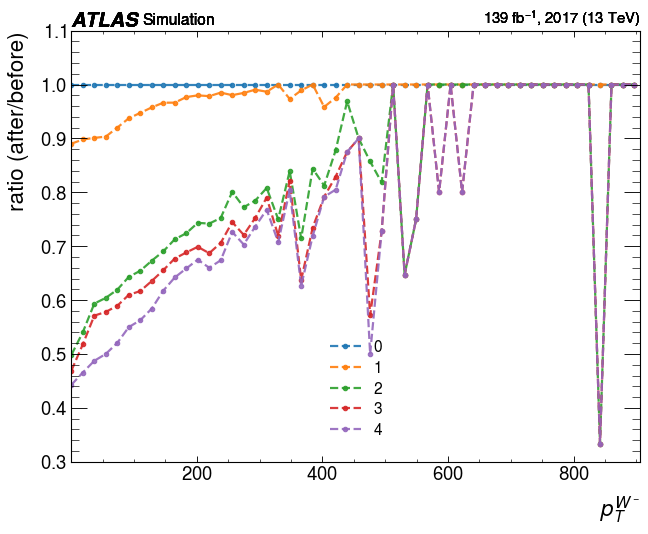

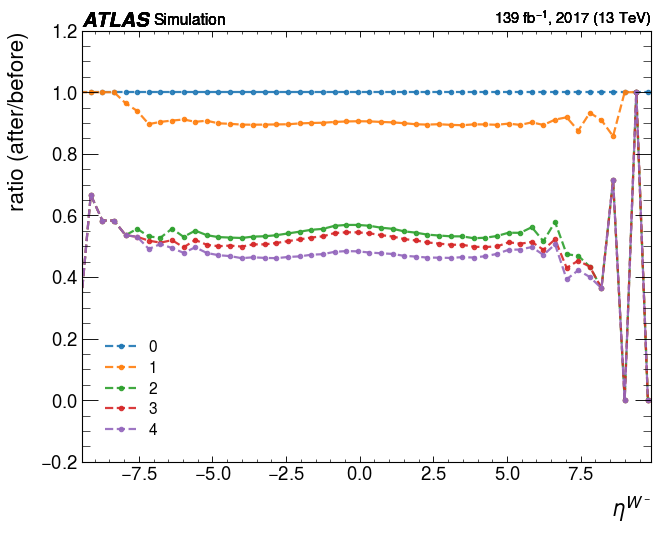

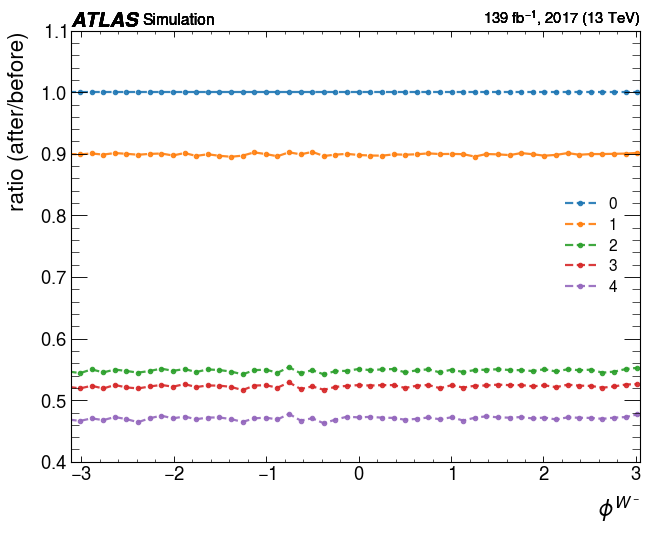

In [41]:
# Wm analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="pt")
    ratio_plot(ratio_data, ylabel=r"$p^{W^-}_{T}$", range=rrange/GEV)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="eta")
    ratio_plot(ratio_data, ylabel=r"$\eta^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="phi")
    ratio_plot(ratio_data, ylabel=r"$\phi^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


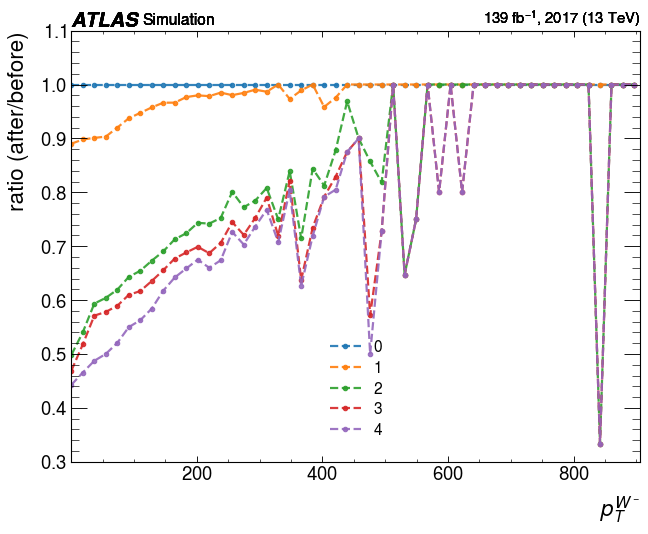

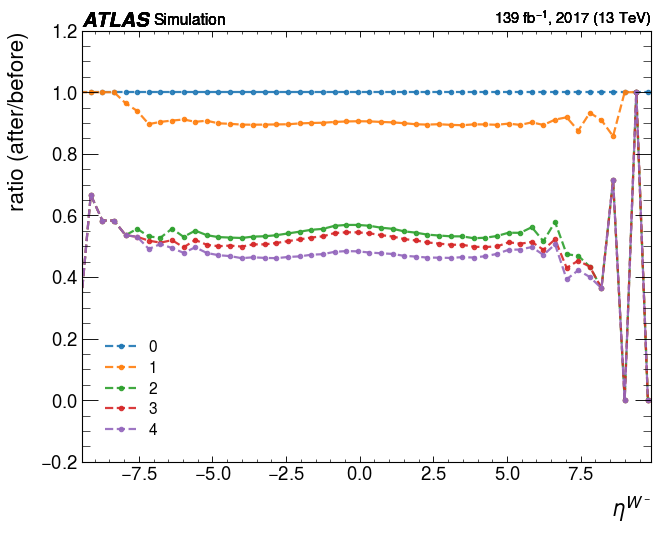

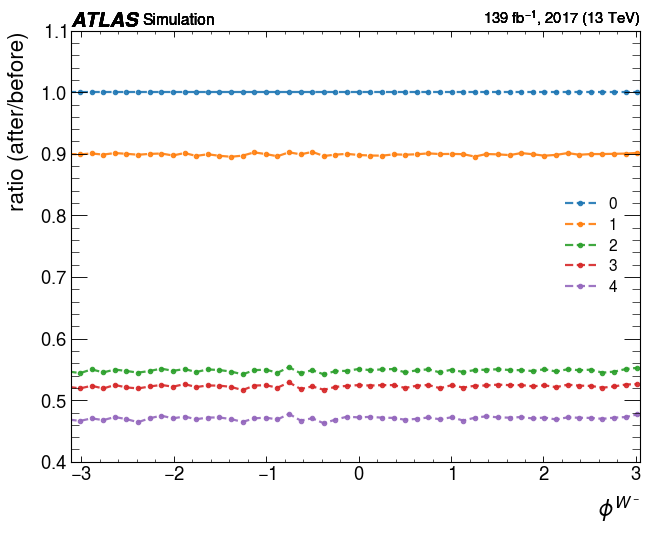

In [42]:
# Wp analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="pt")
    ratio_plot(ratio_data, ylabel=r"$p^{W^-}_{T}$", range=rrange/GEV)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="eta")
    ratio_plot(ratio_data, ylabel=r"$\eta^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wm, var="phi")
    ratio_plot(ratio_data, ylabel=r"$\phi^{W^-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


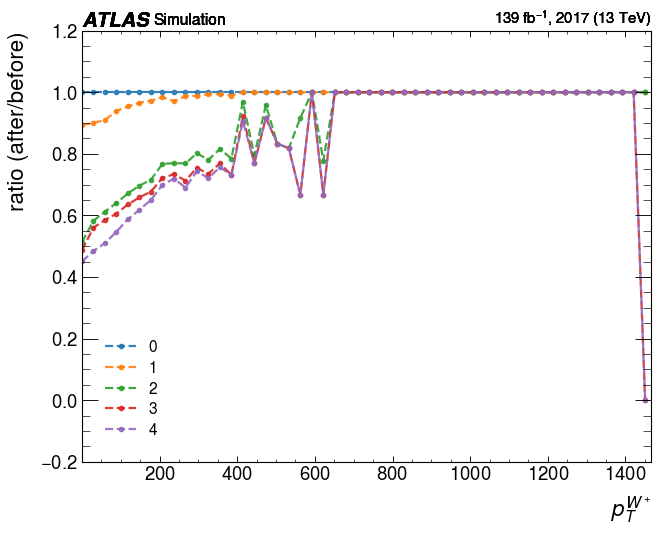

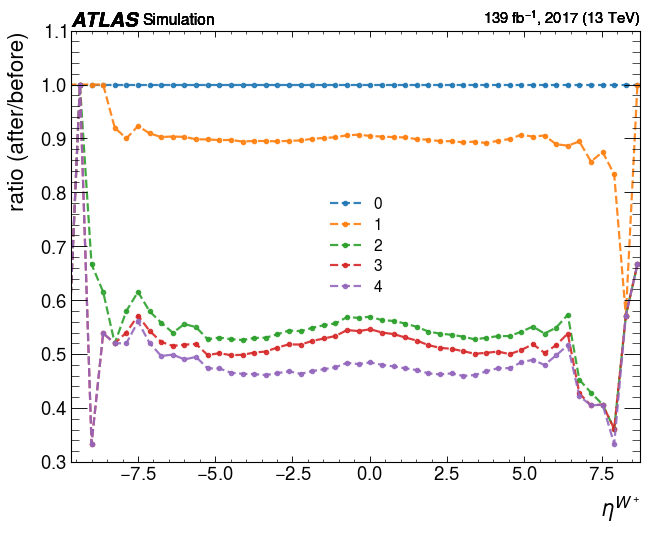

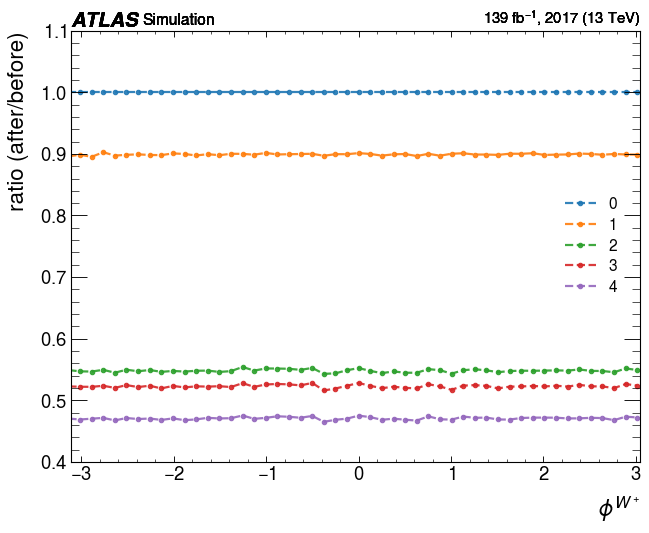

In [43]:
# Wp analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wp, var="pt")
    ratio_plot(ratio_data, ylabel=r"$p^{W^+}_{T}$", range=rrange/GEV)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wp, var="eta")
    ratio_plot(ratio_data, ylabel=r"$\eta^{W^+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Wp, var="phi")
    ratio_plot(ratio_data, ylabel=r"$\phi^{W^+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


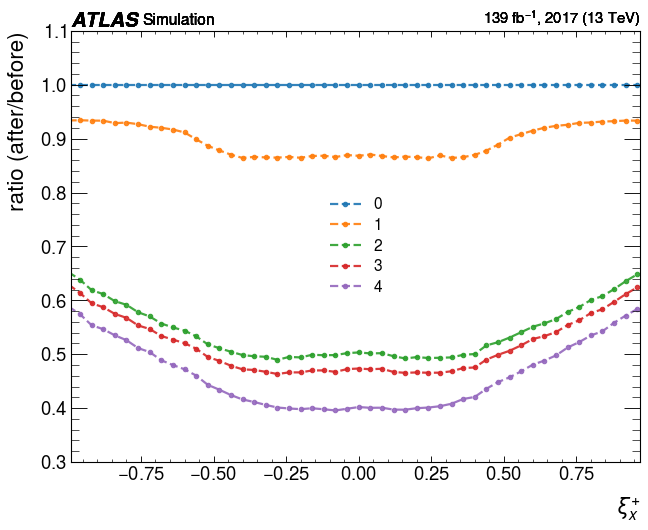

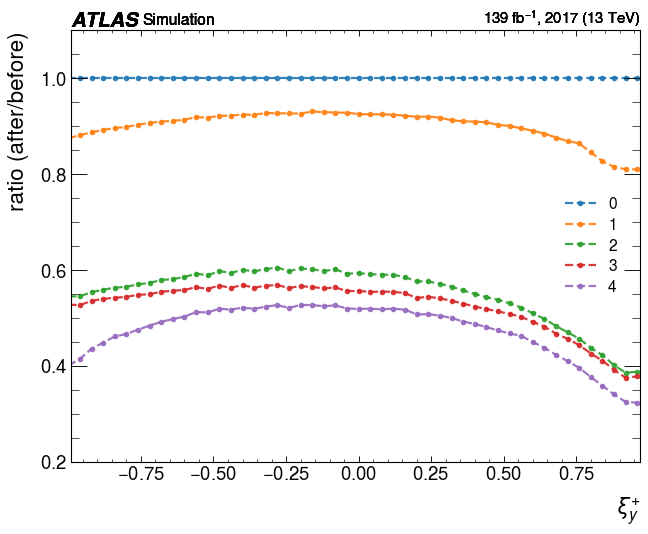

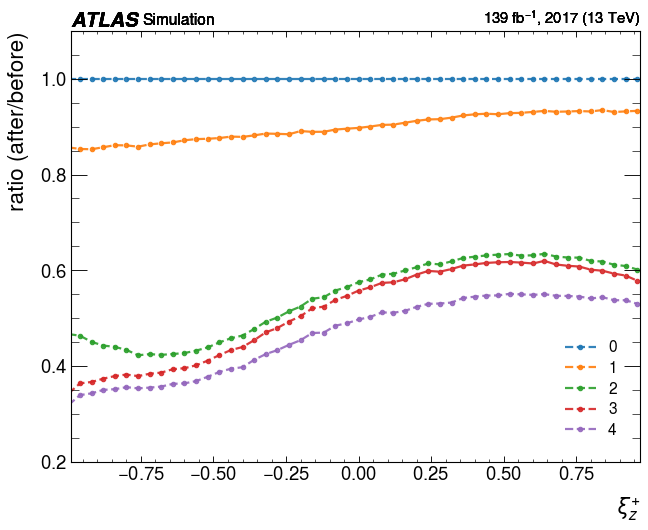

In [44]:
# Xi_p analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_p_x")
    ratio_plot(ratio_data, ylabel=r"$\xi_{x}^{+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_p_y")
    ratio_plot(ratio_data, ylabel=r"$\xi_{y}^{+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_p_z")
    ratio_plot(ratio_data, ylabel=r"$\xi_{z}^{+}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


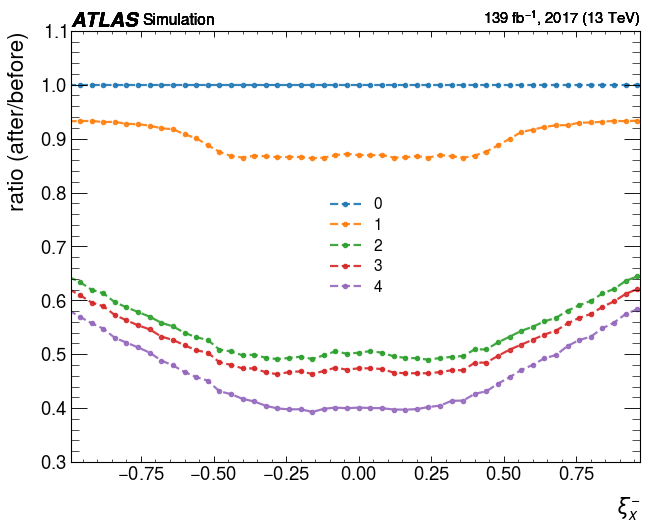

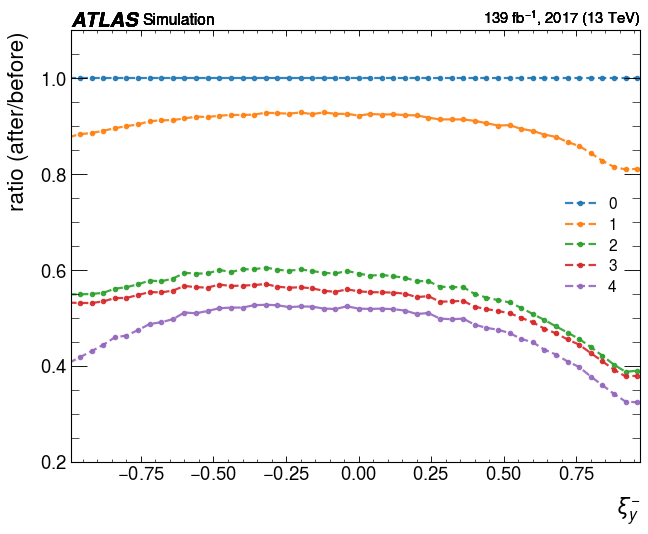

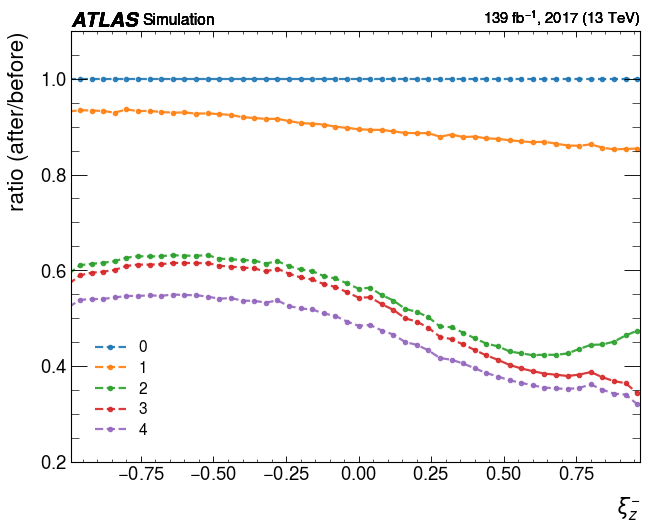

In [45]:
# Xi_m analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_m_x")
    ratio_plot(ratio_data, ylabel=r"$\xi_{x}^{-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_m_y")
    ratio_plot(ratio_data, ylabel=r"$\xi_{y}^{-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=Xi, var="xi_m_z")
    ratio_plot(ratio_data, ylabel=r"$\xi_{z}^{-}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

In [46]:
# CGLMP terms

def term1(xi_p_x, xi_m_x, xi_p_y, xi_m_y):
    return xi_p_x*xi_m_x + xi_p_y*xi_m_y

def term2(xi_p_x, xi_m_x, xi_p_y, xi_m_y):
    return (np.square(xi_p_x) - np.square(xi_p_y))*(np.square(xi_m_x) - np.square(xi_m_y))

def term3(xi_p_x, xi_m_x, xi_p_y, xi_m_y):
    return xi_p_x*xi_p_y*xi_m_x*xi_m_y

In [47]:
term1_xy = term1(Xi["xi_p_x"], Xi["xi_m_x"], Xi["xi_p_y"], Xi["xi_m_y"])
term2_xy = term2(Xi["xi_p_x"], Xi["xi_m_x"], Xi["xi_p_y"], Xi["xi_m_y"])
term3_xy = term3(Xi["xi_p_x"], Xi["xi_m_x"], Xi["xi_p_y"], Xi["xi_m_y"])

term1_yz = term1(Xi["xi_p_y"], Xi["xi_m_y"], Xi["xi_p_z"], Xi["xi_m_z"])
term2_yz = term2(Xi["xi_p_y"], Xi["xi_m_y"], Xi["xi_p_z"], Xi["xi_m_z"])
term3_yz = term3(Xi["xi_p_y"], Xi["xi_m_y"], Xi["xi_p_z"], Xi["xi_m_z"])

term1_zx = term1(Xi["xi_p_z"], Xi["xi_m_z"], Xi["xi_p_x"], Xi["xi_m_x"])
term2_zx = term2(Xi["xi_p_z"], Xi["xi_m_z"], Xi["xi_p_x"], Xi["xi_m_x"])
term3_zx = term3(Xi["xi_p_z"], Xi["xi_m_z"], Xi["xi_p_x"], Xi["xi_m_x"])

df = pd.DataFrame(
    {
        "term1_xy": term1_xy,
        "term2_xy": term2_xy,
        "term3_xy": term3_xy,
        "term1_yz": term1_yz,
        "term2_yz": term2_yz,
        "term3_yz": term3_yz,
        "term1_zx": term1_zx,
        "term2_zx": term2_zx,
        "term3_zx": term3_zx,
    }
)

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


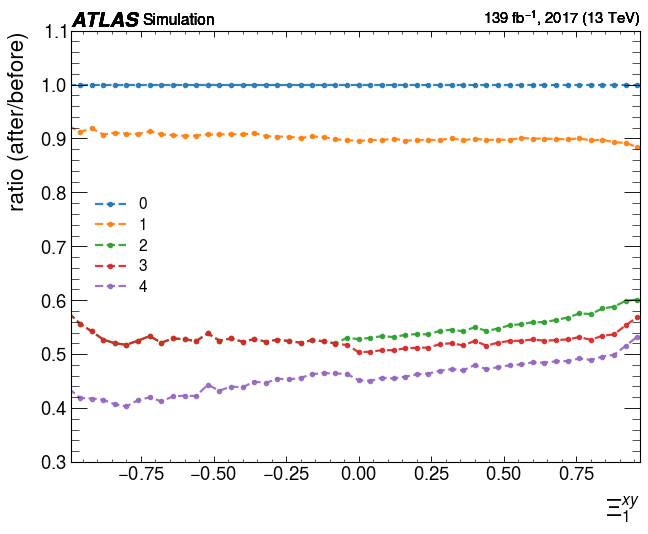

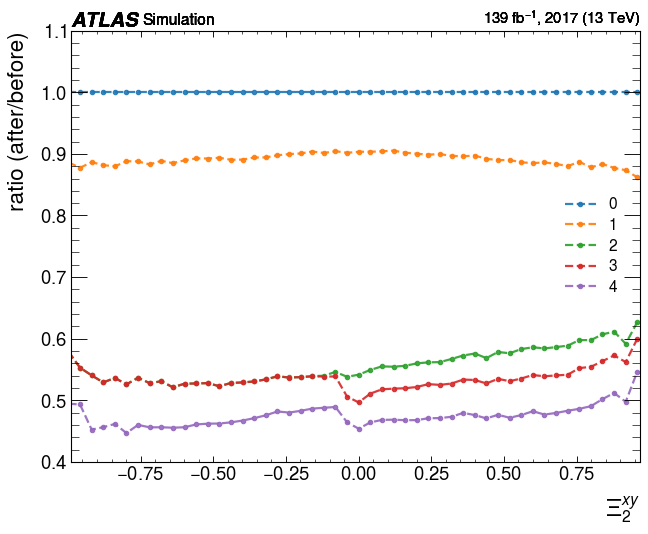

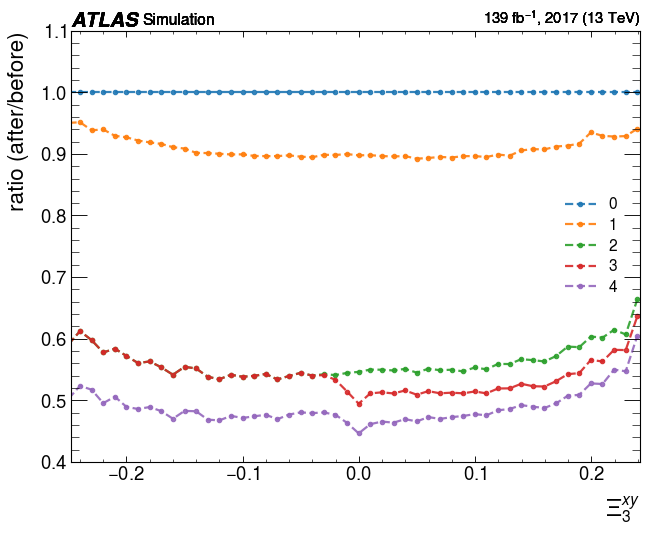

In [48]:
# term_xy analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term1_xy")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{xy}_{1}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term2_xy")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{xy}_{2}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term3_xy")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{xy}_{3}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


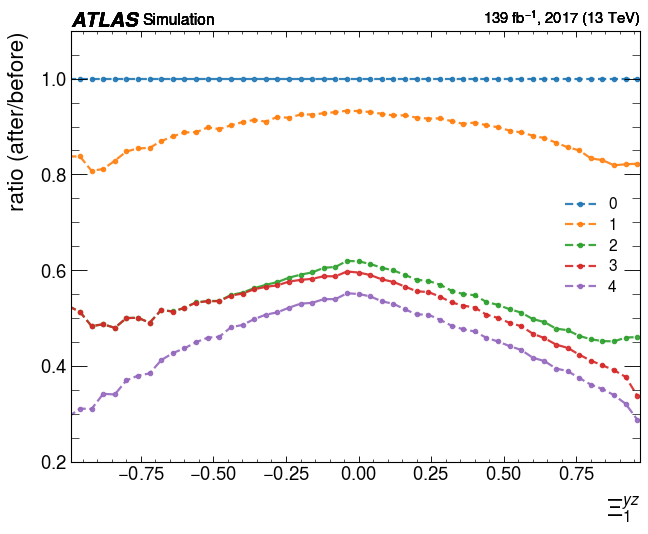

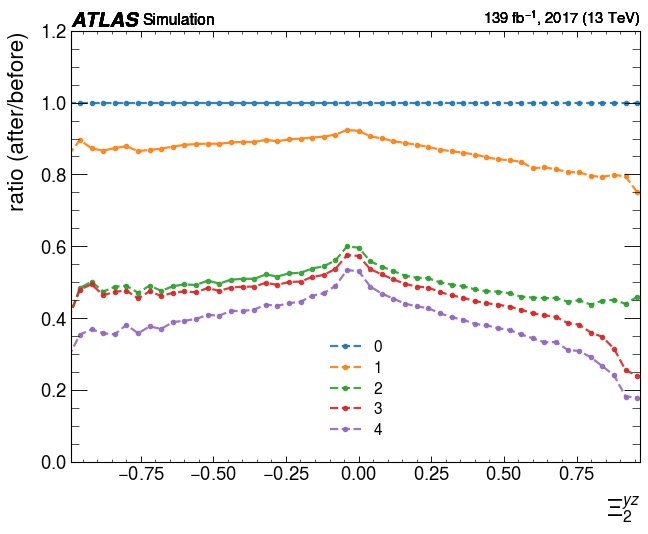

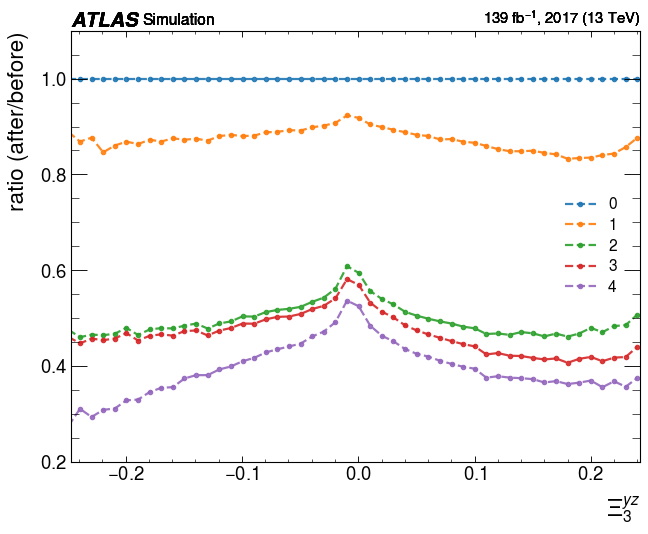

In [49]:
# term_yz analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term1_yz")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{yz}_{1}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term2_yz")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{yz}_{2}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term3_yz")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{yz}_{3}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


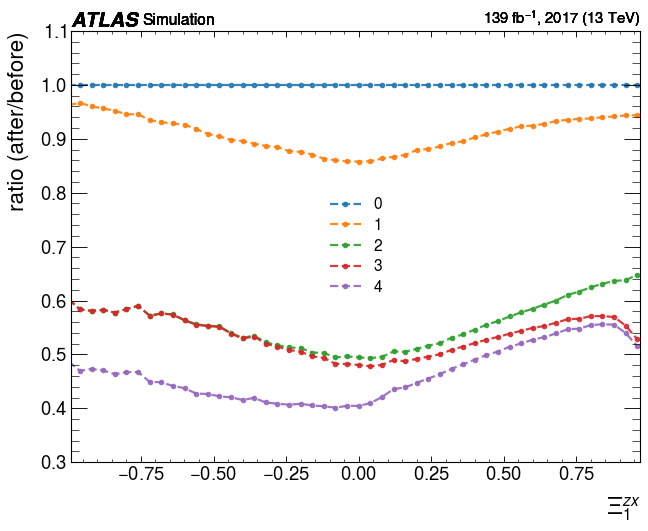

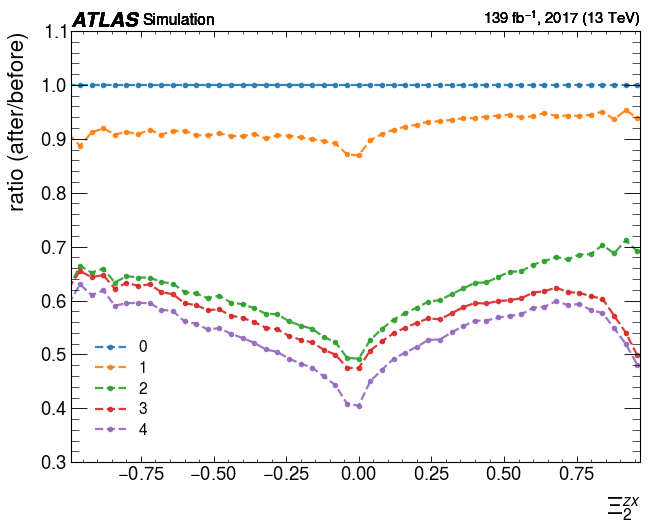

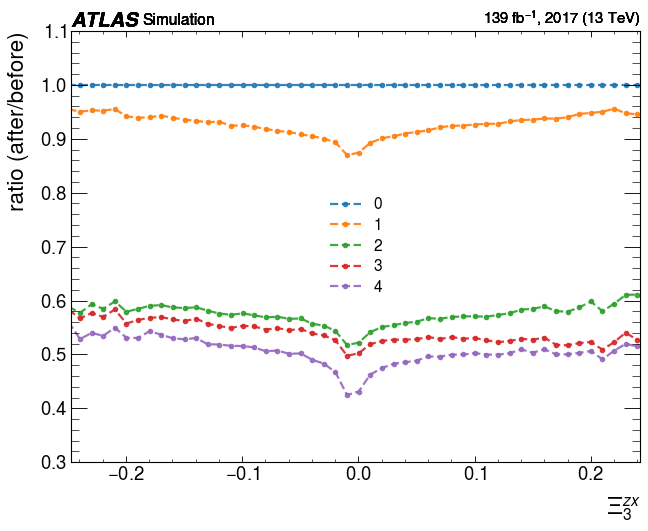

In [50]:
# term_zx analysis

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term1_zx")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{zx}_{1}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term2_zx")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{zx}_{2}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

fig = plt.figure(figsize=(9, 7), dpi=80)
for i in cuts:
    ratio_data, rrange = ratio(i, [], df=df, var="term3_zx")
    ratio_plot(ratio_data, ylabel=r"$\Xi^{zx}_{3}$", range=rrange)
plt.legend(name, loc="best")
plt.show()
plt.close()

In [51]:
# fig = plt.figure(figsize=(9, 7), dpi=80)
# for i in cuts:
#     ratio_data = ratio(i, [], df=SubLep, var="pt")
#     ratio_plot(ratio_data, ylabel=r"$p^{SubLead}_{T}$ [GeV]")
# plt.xlim(-2, 32)
# plt.legend(name, loc="best")
# plt.show()

In [52]:
# fig = plt.figure(figsize=(9, 7), dpi=80)
# for i, j in zip(cuts, name):
#     ratio_data = ratio(i, [], df=MET, var="pt")
#     ratio_plot(ratio_data, ylabel=r"$p^{miss}_{T}$ [GeV]")
# plt.xlim(-2, 32)
# plt.legend(name, loc="best")
# plt.show()

In [53]:
# fig = plt.figure(figsize=(9, 7), dpi=80)
# for i, j in zip(cuts, name):
#     ratio_data = ratio(i, [], df=diLep, var="m")
#     ratio_plot(ratio_data, ylabel=r"$m_{ll}$ [GeV]")
# plt.xlim(-2, 32)
# plt.legend(name, loc="best")
# plt.show()

In [54]:
# CGLMP values analysis

all_cuts = [[], *cuts]
all_name = ["0", *name]
for i, j in zip(all_name, all_cuts):
    CGLMP_analysis(CutName=i, Cuts=j, show=True)

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


# 0
Bxy = 2.210
Bxz = 2.735
Byz = 2.491
-> I3 = 2.735

# 0
Bxy = 2.210
Bxz = 2.735
Byz = 2.491
-> I3 = 2.735

# 1
Bxy = 2.193
Bxz = 2.877
Byz = 2.300
-> I3 = 2.877

# 2
Bxy = 2.542
Bxz = 3.094
Byz = 2.117
-> I3 = 3.094

# 3
Bxy = 2.106
Bxz = 2.851
Byz = 1.890
-> I3 = 2.851

# 4
Bxy = 2.364
Bxz = 3.110
Byz = 1.964
-> I3 = 3.110



/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


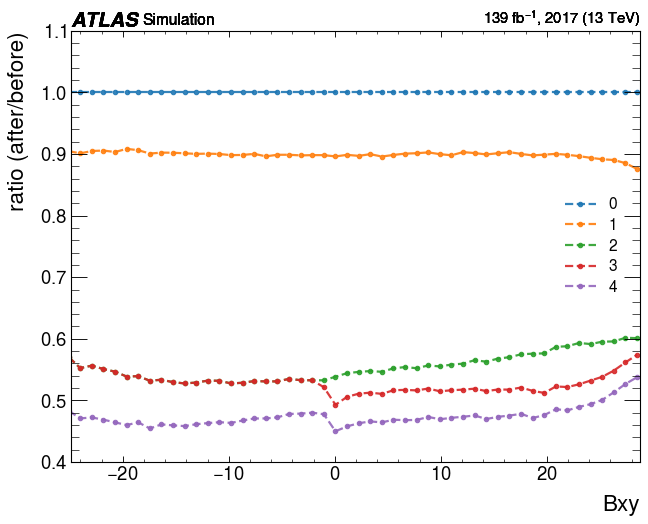

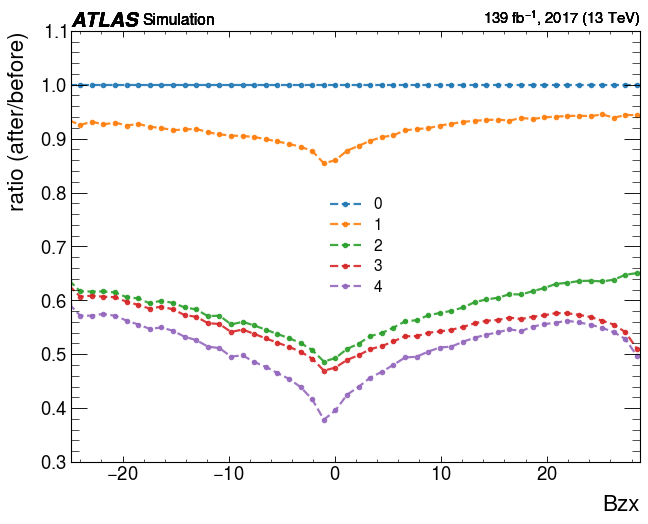

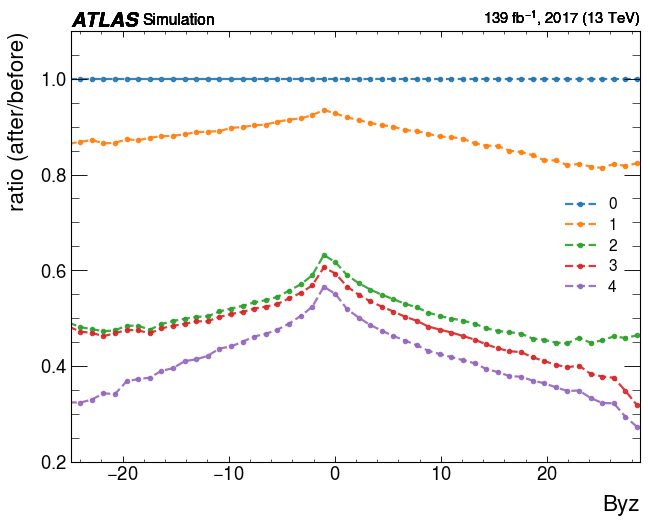

In [55]:
# CGLMP cuts analysis

for var in ["Bxy", "Bzx", "Byz"]:
    fig = plt.figure(figsize=(9, 7), dpi=80)
    for i, j in zip(cuts, name):
        ratio_data, rrange = ratio(i, [], df=CGLMP, var=var)
        ratio_plot(ratio_data, ylabel=var, range=rrange)
    plt.legend(name, loc="best")
    plt.show()

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


Use same units...

Data 0:
    The average of CutAnalysis is 0.26295;
    The STD     of CutAnalysis is 0.41617;
    The SEM     of CutAnalysis is 0.00026599.


Data 1:
    The average of CutAnalysis is 0.27029;
    The STD     of CutAnalysis is 0.42049;
    The SEM     of CutAnalysis is 0.00028343.


Data 2:
    The average of CutAnalysis is 0.28594;
    The STD     of CutAnalysis is 0.42534;
    The SEM     of CutAnalysis is 0.00036723.


Data 3:
    The average of CutAnalysis is 0.27276;
    The STD     of CutAnalysis is 0.42581;
    The SEM     of CutAnalysis is 0.00037643.


Data 4:
    The average of CutAnalysis is 0.30353;
    The STD     of CutAnalysis is 0.41732;
    The SEM     of CutAnalysis is 0.0003888.



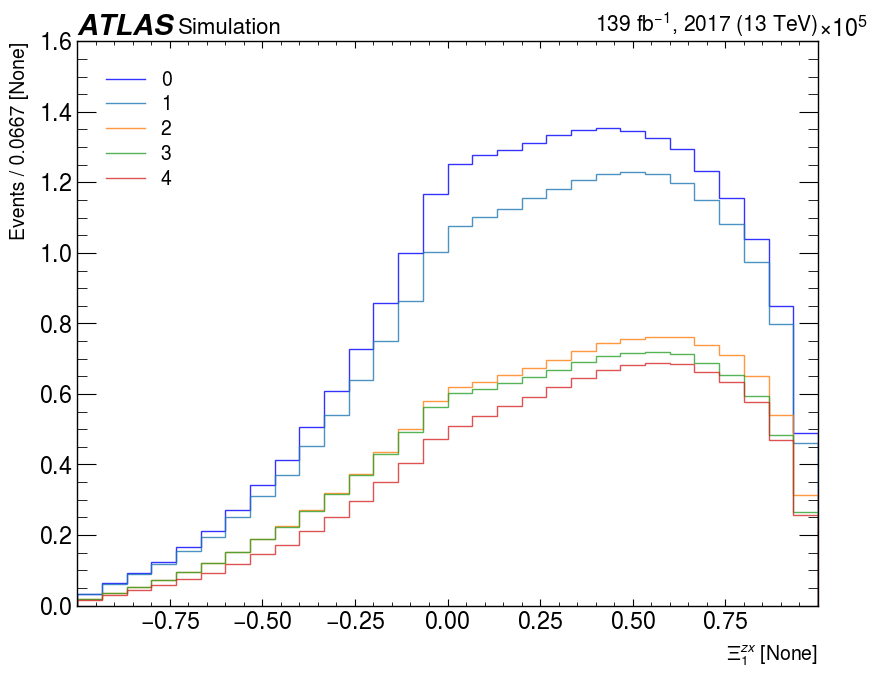

1D, Finish!


In [56]:
data = [df[CGLMP_analysis(Cuts=cuts[i])]["term1_zx"] for i in np.arange(len(cuts))]
plot(data, xlabel=r"$\Xi^{zx}_{1}$", label=name, loc=0)

### Correlation study

In [57]:
def corr_matrix(df: pd.DataFrame, title: str, barrange=[-0.1, 1]) -> None:
    corr_matrix = df.corr()
    plt.style.use("default")
    _, ax = plt.subplots(figsize=(15, 15), dpi=120)
    im = ax.imshow(corr_matrix.values, cmap="Blues", vmin=barrange[0], vmax=barrange[1])
    ax.set_xticks(np.arange(len(corr_matrix.columns)))
    ax.set_yticks(np.arange(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns)
    ax.set_yticklabels(corr_matrix.columns)
    # rotate tick labels
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=10,
    )
    plt.setp(ax.get_yticklabels(), fontsize=10)
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.85)
    cbar.ax.tick_params(labelsize=10)
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            ax.text(
                j,
                i,
                round(corr_matrix.values[i, j], 2),
                ha="center",
                va="center",
                color="w",
            )
    ax.set_title(f"Correlation Matrix ({title})", fontsize=14)
    # add black lines to separate blocks
    for n in range(6):
        ax.axvline(x=3.5 + 4 * n, color="grey", linewidth=1)
        ax.axhline(y=3.5 + 4 * n, color="grey", linewidth=1)

    plt.show()
    plt.close()

    return


In [58]:
df = pd.DataFrame(
    {
        "LeadLep_px": LeadLep["px"],
        "LeadLep_py": LeadLep["py"],
        "LeadLep_pz": LeadLep["pz"],
        "LeadLep_E": LeadLep["E"],
        "SubLep_px": SubLep["px"],
        "SubLep_py": SubLep["py"],
        "SubLep_pz": SubLep["pz"],
        "SubLep_E": SubLep["E"],
        "LmNu_px": LmNu["px"],
        "LmNu_py": LmNu["py"],
        "LmNu_pz": LmNu["pz"],
        "LmNu_E": LmNu["E"],
        "LpNu_px": LpNu["px"],
        "LpNu_py": LpNu["py"],
        "LpNu_pz": LpNu["pz"],
        "LpNu_E": LpNu["E"],
        "Wp_px": Wp["px"],
        "Wp_py": Wp["py"],
        "Wp_pz": Wp["pz"],
        "Wp_E": Wp["E"],
        "Wm_px": Wm["px"],
        "Wm_py": Wm["py"],
        "Wm_pz": Wm["pz"],
        "Wz_E": Wm["E"],
        "Higgs_px": Higgs["px"],
        "Higgs_py": Higgs["py"],
        "Higgs_pz": Higgs["pz"],
        "Higgs_E": Higgs["E"],
    }
)

/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_6717/588006348.py:4: UserWarning: No cut applied...
  warnings.warn("No cut applied...")


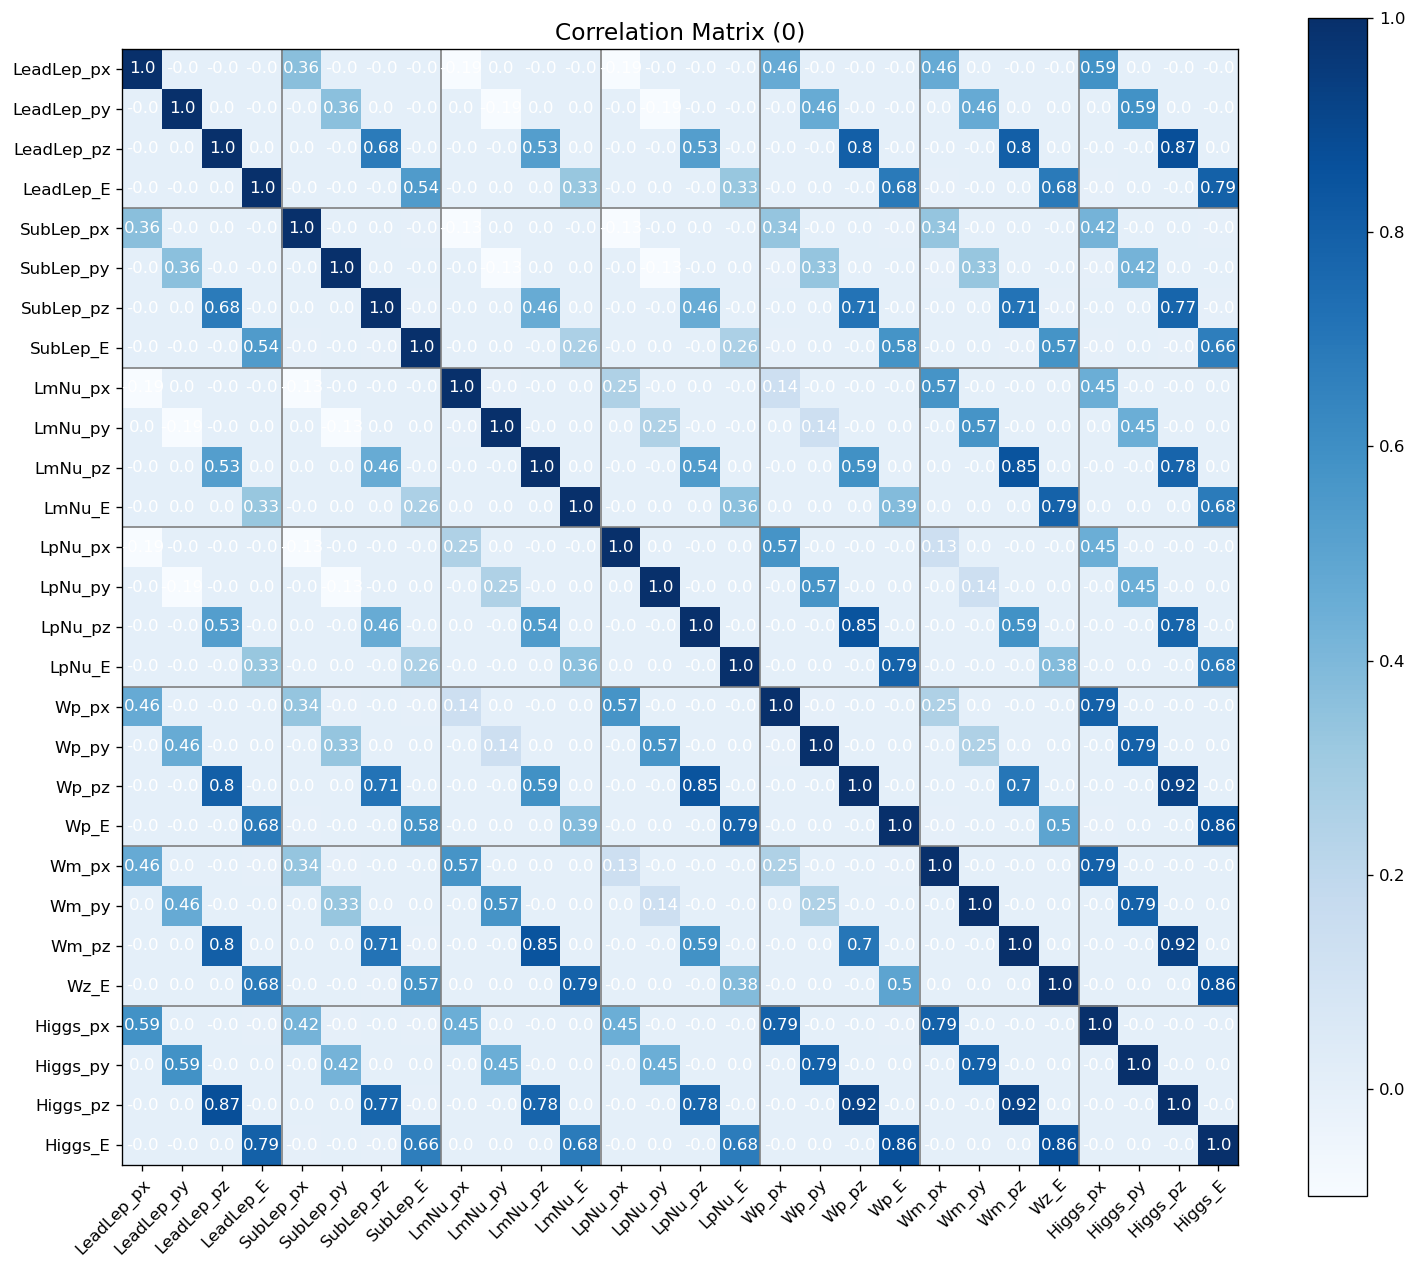

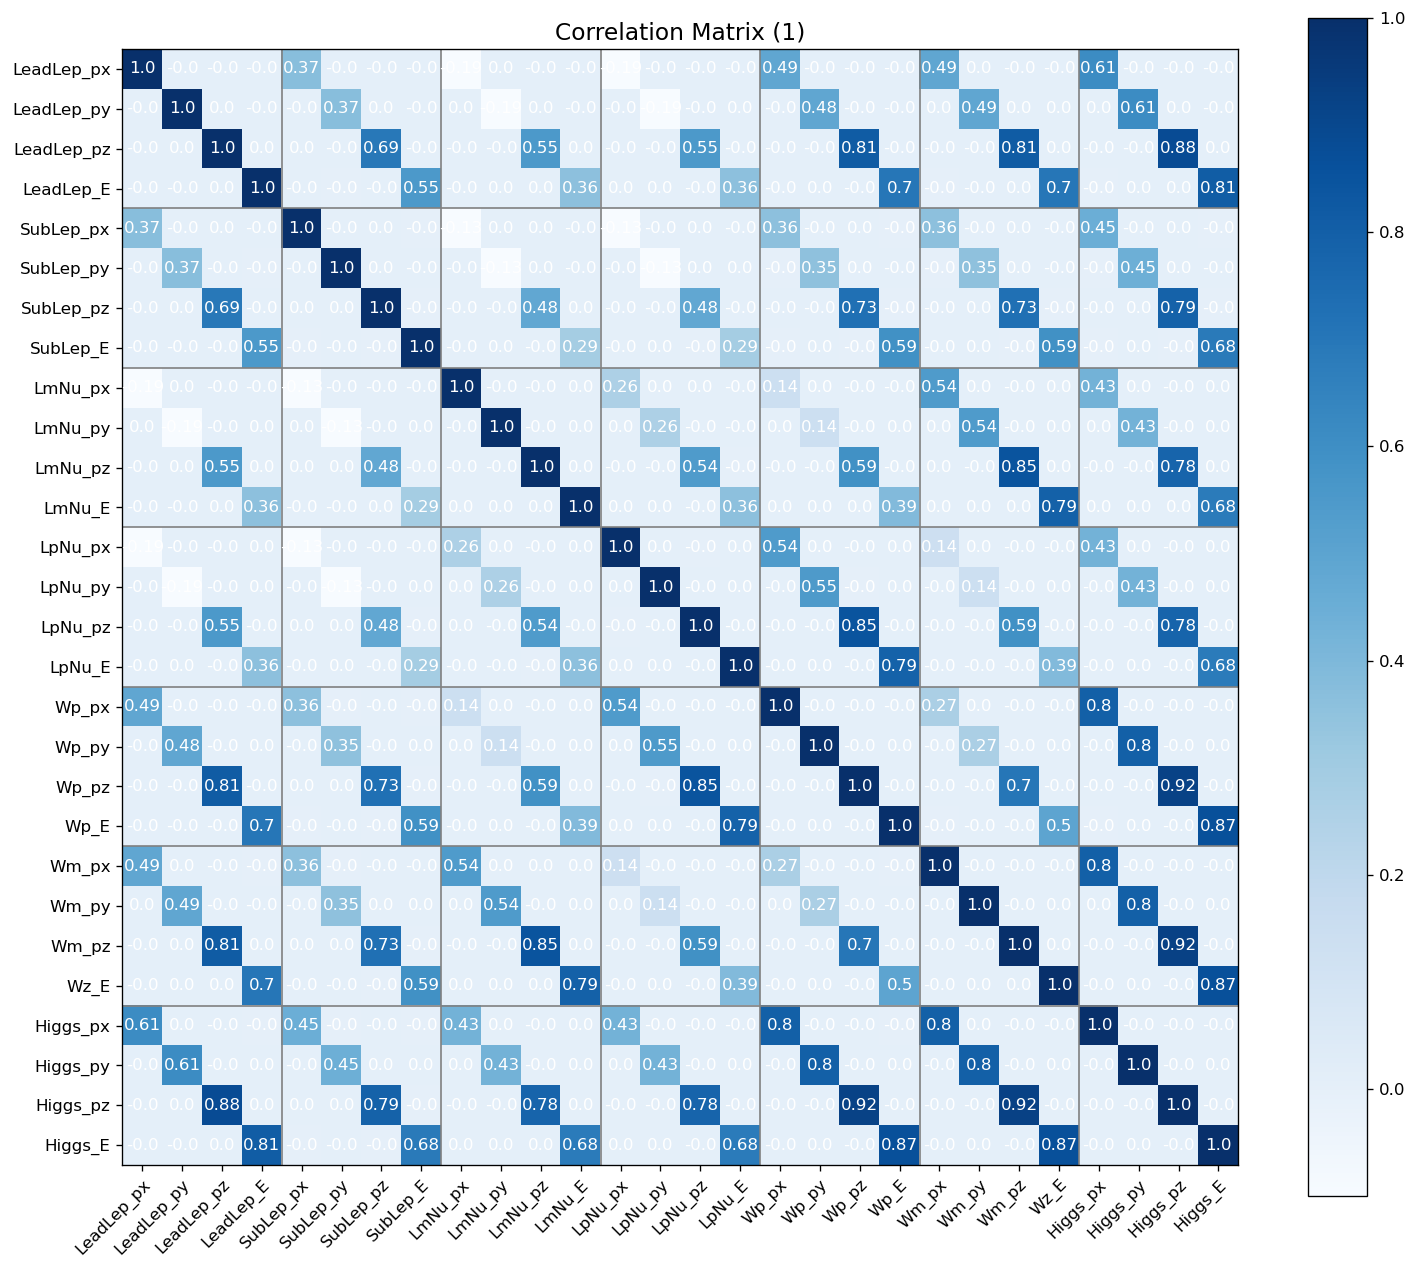

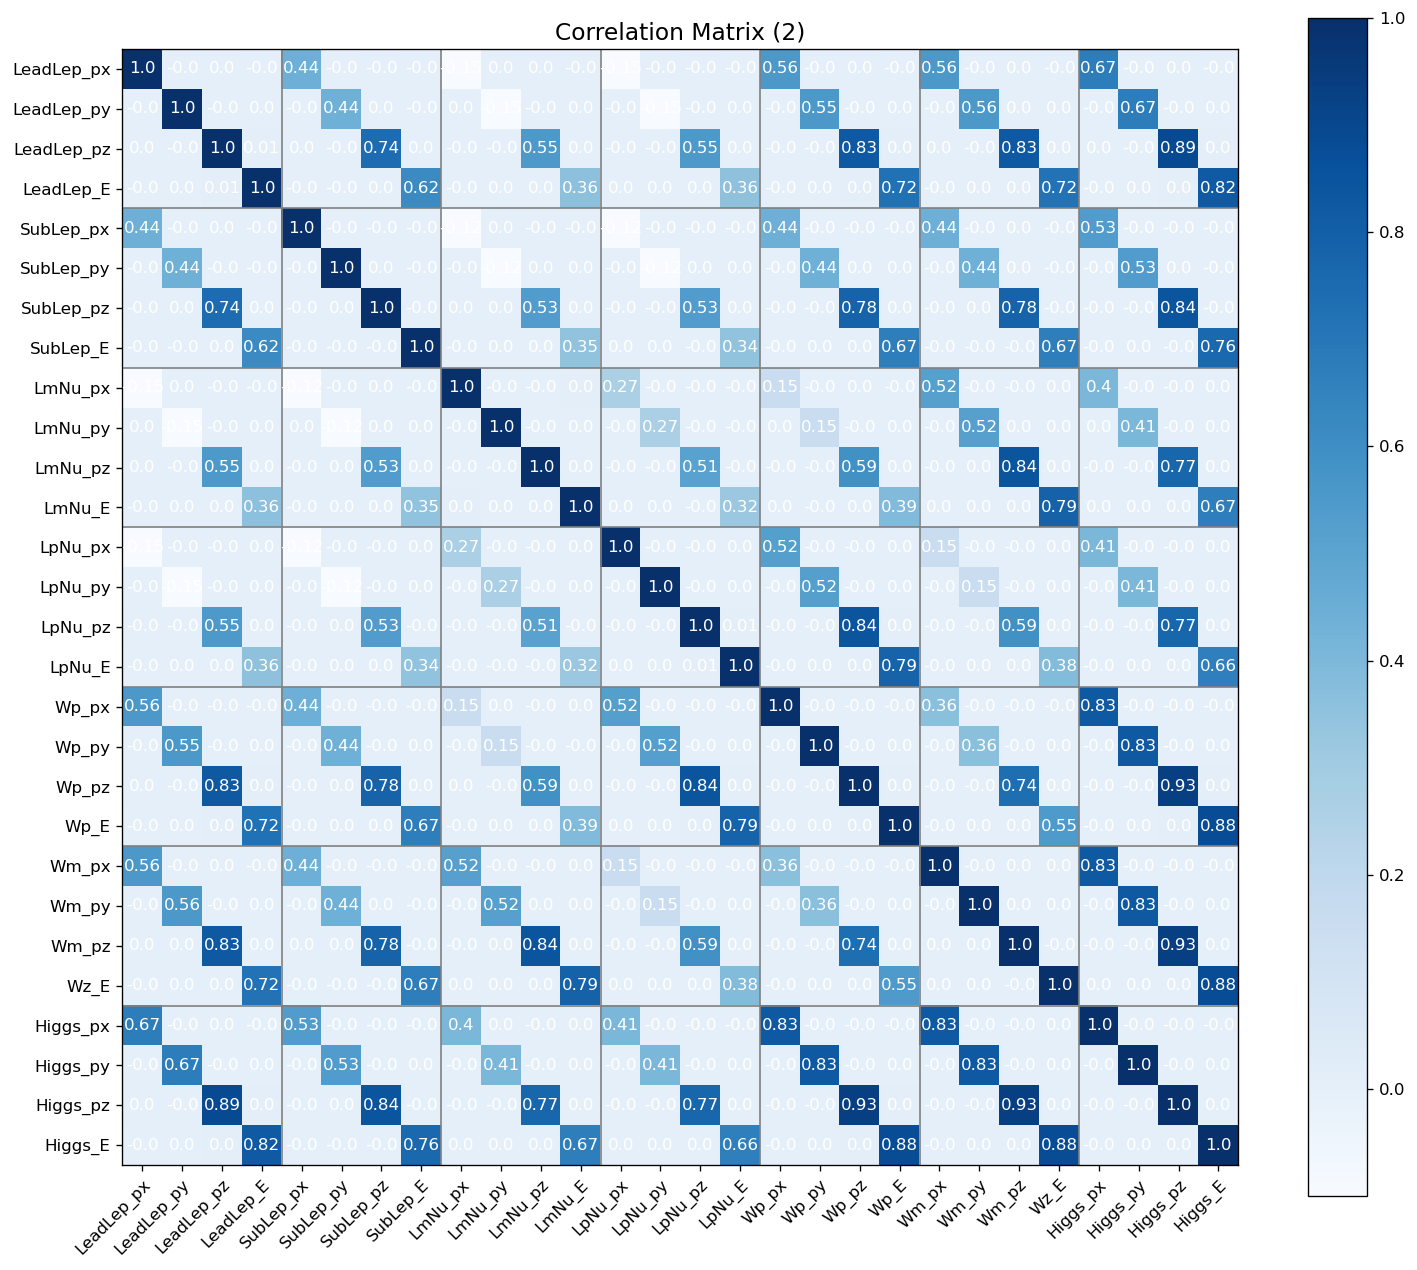

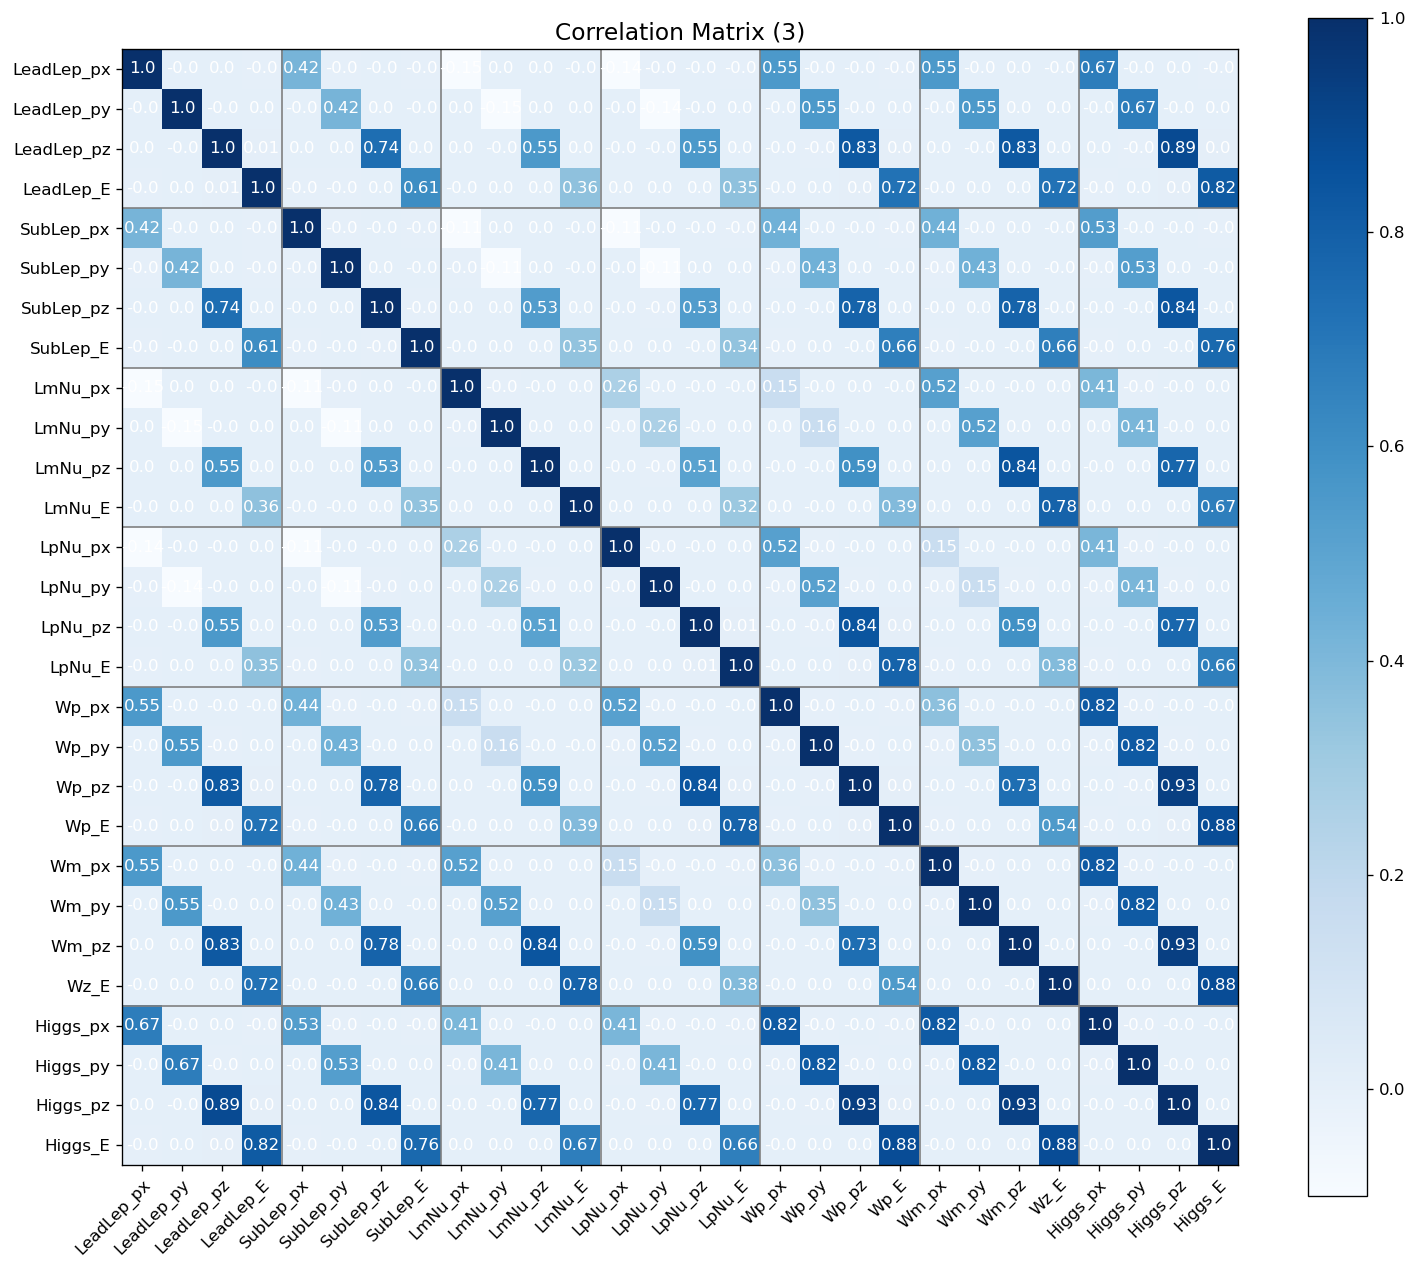

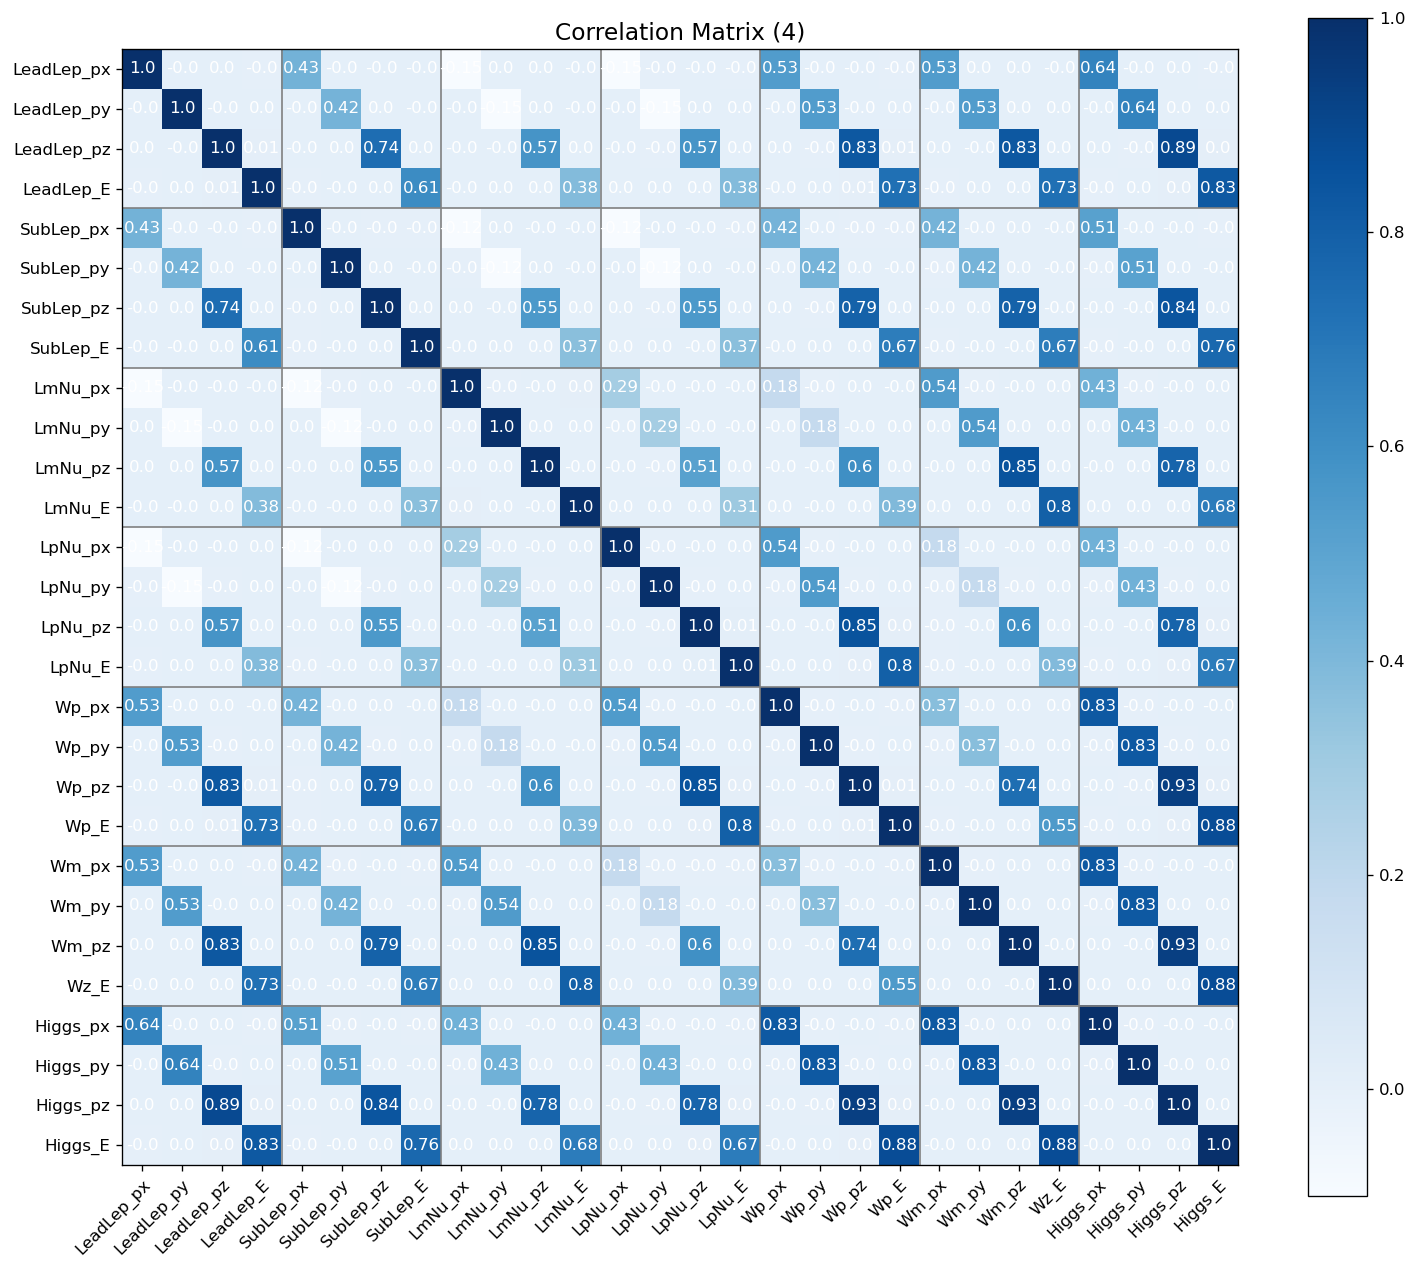

In [59]:
for i, j in zip(cuts, name):
    cut_data = df[CGLMP_analysis(Cuts=i)] / GEV
    corr_matrix(cut_data, j)